# Modeling M100 Lateness

Here we're trying to model the M100's lateness and simulated crowdedness in the St. Nicholas stop going to Inwood 220 St Via Amsterdam Via Bway. 

We are applying Datacamp's Decision-Tree for Classification

## Table of Contents:
1. [Choosing the Appropriate Classifier](#choosing-the-appropriate-classifier)
1. [Plotting a Chart for Sanity](#plotting-a-chart-for-sanity)
1. [Saving our Progress](#saving-our-progress)
1. [Model Training](#model-training)\*
1. [Data Cleaning](#data-cleaning)\*

\* Not finished yet

Prequisites (if you want to follow along/verify results)

In [9]:
# !pip3 install --user -U scikit-learn==0.18
!pip3 install --user -U seaborn

  Found existing installation: seaborn 0.8
    Uninstalling seaborn-0.8:
      Successfully uninstalled seaborn-0.8


In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import datetime as dt

warnings.filterwarnings("ignore")
random_state = 20181112
import datetime, math, glob

Adding data from the M100 csv file.

# Choosing the Appropriate Classifier

We want (a) regressor(s) that can predict the **wait time** and **crowding** of a bus at a specific stop with the inputs **hourly weather** and **time of day**. We would most likely have two models that predict each **wait time** and **crowding**.

Here are our top picks for regressors:

1. Gradient Boosting Machines ***(top pick)***:
    - Why: GBMs are typically a composite model that combines the efforts of multiple weak models to create a strong model, and each additional weak model reduces the mean squared error (MSE) of the overall model. Our goal would be to minimize MSE to increase the accuracy of our predictions.

1. Random Forest:
    - Why: does not suffer from the overfitting like with Decision Trees. Instead of randomly choosing to split from just **hourly weather** and **time of day**, we can have two trees that randomly split from each and find the best model. 

1. Decision Trees:  
    - Reduction in Standard Deviation (metric): This is a regression metric that measures how much we’ve reduced our uncertainty by picking a split point. By picking the best split each time the greedy decision tree training algorithm tries to form decisions with as few splits as possible.  
    - Hyperparameters:   
        * Max depth: Limit our tree to a `n` depth to prevent overfitting.
        

Evaluating our model:

Since we're creating regression models, we are interested in the ***mean squared error*** and ***R Squared***. The lower our ***R Squared*** the more accurate our model. We intend to use **K-fold cross validation** as well as a **holdout set** as we improve our model through hyperparameter tuning. 


# Data Cleaning

> Please checkout [this notebook](../Bus_Timeline/Excel_Bus_Timeline_Draft.ipynb) on how we did the cleaning process

1. Clean and break up the time components (Hour, Mins, Secs) of the following:
    * `RecordedAtTime`
2. Merge and store (we'll merge them based on the hour of the day and the day of the month):
    * Bus
        * `Hour`
        * `Min`
        * `Sec`
        * `Day`
    * Weather
        * `Hour`
        * `HourlyVisibility`
        * `HourlyPrecipitation`
        * `HourlyWindSpeed`
3. Features of interest:
    * `Hour`
    * `Min`
    * `Sec`
    * `HourlyVisibility`
    * `HourlyPrecipitation`
    * `HourlyWindSpeed`
4. Prediction result:
    * `timeTillNext`: estimated minutes remaining until next bus

### Loading our Merged Tables

In [4]:
df = pd.read_csv('../../data/Merged_Bus_Weather.csv')

# Model Training I

Adapted from: https://shankarmsy.github.io/stories/gbrt-sklearn.html

In [11]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings, seaborn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split


np.random.seed(sum(map(ord, "aesthetics"))) 
seaborn.set_context('notebook') 
# pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier 
plt.rcParams['figure.figsize'] = (15, 5) # Set some Pandas options 
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 40) 
pd.set_option('display.max_rows', 25) 
pd.options.display.max_colwidth = 50 


## Features, Targets and Splitting

In [12]:
features = (['Hour', 'Sec', 'Min', 'HOURLYVISIBILITY', 'HOURLYWindSpeed', 'HOURLYPrecip'])

target = 'timeTillNext'

model_df = df[(features + [target])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df[target], test_size=0.2,
    random_state=random_state)

train_df[target] = y_train
holdout_df[target] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df.timeTillNext.mean())
print(holdout_df.shape[0], holdout_df.timeTillNext.mean())

4580 7.399024745269249
1146 6.63468586387436


In [13]:
X_train = train_df
X_test = holdout_df
y_train = y_train
y_test = y_holdout

## The Gradient Boosting Regression Tree

In [15]:
gbrt=GradientBoostingRegressor(n_estimators=100) 
train_df.shape

gbrt.fit(train_df, y_train) 
y_pred=gbrt.predict(holdout_df) 

## Designing the model

In [16]:
k_fold = KFold(n_splits=5, random_state=random_state)

Setting up models:

In [17]:
def get_cv_results(regressor):
    
    mse = []
    for train, test in k_fold.split(train_df):
        regressor.fit(train_df.loc[train, features], train_df.loc[train, target])
        y_predicted = regressor.predict(train_df.loc[test, features])
        
        mean_squared = mean_squared_error(train_df.loc[test, target], y_predicted)
        mse.append(mean_squared)
    
    return np.mean(mse), np.std(mse)

In [18]:
gbm = GradientBoostingRegressor(
    random_state=random_state, 
    learning_rate = 0.01,
    min_samples_split=4,
    max_depth=6,
    n_estimators=100
)

results = get_cv_results(gbm)

print("Mean of mean squared error:", results[0])
print("Mean squared error std:", results[1])

Mean of mean squared error: 419.02967336966486
Mean squared error std: 119.12337466784993


How about we change some hyperparameters and see what the outcomes are?

In [19]:
gbm = GradientBoostingRegressor(
    random_state=random_state, 
    learning_rate = 0.01,
    min_samples_split=4,
    max_depth=4,
    n_estimators=500
)

results = get_cv_results(gbm)

print("Mean of mean squared error:", results[0])
print("Mean squared error std:", results[1])

Mean of mean squared error: 454.6817982976453
Mean squared error std: 62.59176536871218


Looking at learning curves

In [20]:
hp_values = range(1,20, 2)
all_mu = []
all_sigma = []

for m in hp_values:

    gbrm=GradientBoostingRegressor(
        random_state=random_state, 
        max_depth=m,
    )

    mu, sigma = get_cv_results(gbrm)
    all_mu.append(mu)
    all_sigma.append(sigma)
    
    print(m, mu, sigma)

1 390.80399311847646 104.18459182278363
3 439.7836235276709 65.86990330040972
5 516.7649933591526 79.21121881103716
7 562.1871400790455 54.53735144509007
9 549.7601315247587 67.4844842933805
11 609.7318253349222 94.87656480846519
13 621.2292168263954 95.91143528866438
15 626.2541454348714 96.76767865609375
17 642.8358221991883 99.08794425949475
19 634.9265246495809 87.76050394413882


Text(0.5, 0, 'Max Depth')

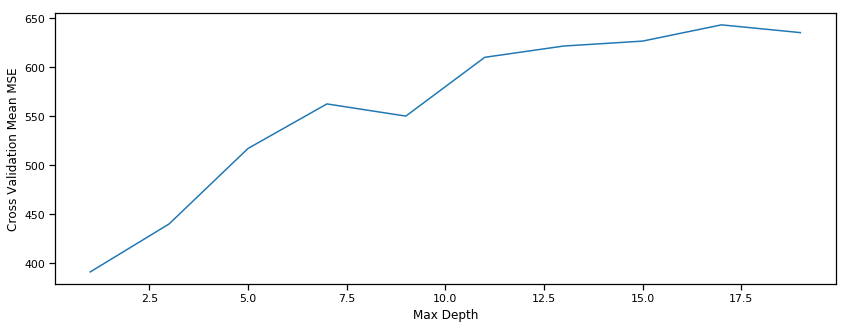

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_mu)
plt.ylabel('Cross Validation Mean MSE')
plt.xlabel('Max Depth')

Text(0.5, 0, 'Max Depth')

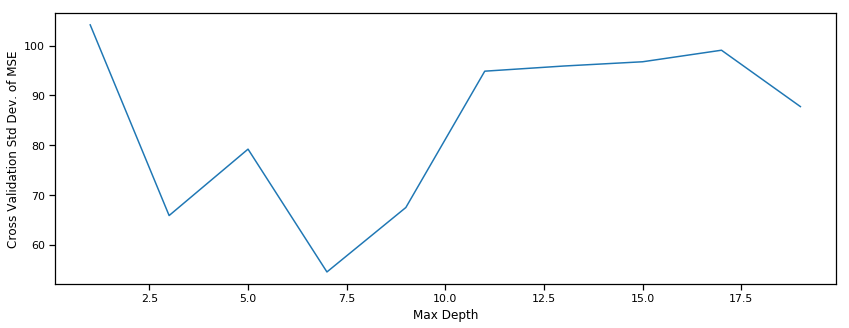

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_sigma)
plt.ylabel('Cross Validation Std Dev. of MSE')
plt.xlabel('Max Depth')

### Area Under the ROC curve 

In [ ]:
def plot_roc(regressor, label, color):

    regressor.fit(train_df[features], train_df[target])
    y_prob = regressor.predict(holdout_df[features])
    
    fpr, tpr, thresh = roc_curve(holdout_df[target], y_prob)
    plt.plot(fpr, tpr,
             label=label,
             color=color, linewidth=3)

    auc = roc_auc_score(holdout_df[target], y_prob[:,1])
    
    print('AUC: %0.3f (%s)' % (auc, label))

In [ ]:
f1 = plt.figure(figsize=(14,6))
gbm = GradientBoostingRegressor(
    random_state=random_state, 
    learning_rate = 0.01,
    min_samples_split=4,
    max_depth=6,
    n_estimators=100
)

plot_roc(gbm, 'GBM', 'lightblue')


In [ ]:

title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()


In [ ]:
#Let's try one more trick. We'll trim the training set to its most important features and re-train to see if 
#that helps.
title = "Learning Curves (Gradient Boosted Regression Trees)" 

#Dropping all parameters except n_estimators and learning_rate since we're going to trim the features anyway.
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, learning_rate=best_est.learning_rate)

#Calling fit on the estimator so we can transform the X matrices.
estimator.fit(X_train, y_train)

#Trimming feature matrices to include only those features that are more important than the mean of all importances.
# X_train_trim=estimator.transform(X_train, threshold='mean')

# #Trimming test as well in case we end up going with this model as final.
# X_test_trim=estimator.transform(X_test, threshold='mean')

#Re-plotting Learning cruves.
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#So what do we infer from this plot? We seem to have addressed overfitting much better but the overall score of both train
#and cv has gone down considerably, indicating that the features we dropped were actually collectively contributing
#to the model. Let's go back to the first model that the Grid Search returned and run our test scores.


In [ ]:
#Switching back to the best model from gridsearch
estimator = best_est

#Re-fitting to the train set
estimator.fit(X_train, y_train)

#Calculating train/test scores - R-squared value
print("Train R-squared: ", estimator.score(X_train, y_train))
print("Test R-squared: ", estimator.score(X_test, y_test))

#There you have it, our final R-squared on the California housing dataset, 0.82

# Saving/Loading the Model


Credit: https://scikit-learn.org/stable/modules/model_persistence.html

In [ ]:
# !pip3 install -U --user joblib

In [ ]:
# Saving
from joblib import dump, load
dump(estimator, '../../data/GBRT_Hamlet.joblib') 

In [ ]:
# Loading
model = load('../../data/GBRT_Hamlet.joblib') 

## Modelling III: More examples of hyperparameter tuning

In [ ]:
#OK let's run through a more complex example this time. We'll explore anonymous loan data provided by lendingclub. 
#We'll try to predict the interest rate for loan applications based on data provided. Let's first download data to 
#a pandas df.

#The Dataset is a zip file. So let's first read in the dataset through requests then pass it on to Pandas through the
#read_csv command
url=requests.get('https://resources.lendingclub.com/LoanStats3c.csv.zip')
z=zipfile.ZipFile(io.StringIO(url.content))

loan=pd.read_csv(z.open('LoanStats3c.csv'), skiprows=1, parse_dates=True, index_col='id')
loanbk=loan.copy() #Backup of the dataframe so we don't have to download data everytime

In [ ]:
#Let's take a quick peek at the dataset
loan.describe()

In [ ]:
#For simplicity, let's first drop nulls in the dataset. axis=1 indicates we'll drop rows not cols.
loan = loan.dropna(axis=0)

In [ ]:
#OK let's take a look at the columns and see if there are any we can drop any before we get started.
loan.columns.values

#There're plenty that don't seem very relevant. Let's drop them.
loan=loan.drop(['member_id', 'grade', 'sub_grade', 'emp_title', 'issue_d',
          'pymnt_plan', 'url', 'desc', 'title', 'initial_list_status',
          'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
          'policy_code', 'emp_length', 'addr_state','zip_code'], axis=1)

#Check the data dictionary for this dataset at https://resources.lendingclub.com/LCDataDictionary.xlsx for more details

In [ ]:
# Get rid of non-numeric values throughout the DataFrame:
for col in loan.columns.values:
  loan[col] = loan[col].replace('[^0-9]+.-', '', regex=True)
loan.head(2)

In [ ]:
#Remove % symbol from the interest rate & revolving utilization
loan.int_rate=loan.int_rate.str.split('%',1).str[0]
loan.revol_util=loan.revol_util.str.split('%',1).str[0]

#Remove "months" from the loan period
loan.term=loan.term.str.split(' ',2).str[1]

loan.head(2)

In [ ]:
#Let's change the Income Verified column, which currently has textual labels to numeric.
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
loan.is_inc_v = le.fit_transform(loan.is_inc_v.values)
loan.home_ownership=le.fit_transform(loan.home_ownership.values)
loan.loan_status=le.fit_transform(loan.loan_status.values)
loan.purpose=le.fit_transform(loan.purpose.values)

#Finally let's be sure we convert all fields to numeric
loan=loan.convert_objects(convert_numeric=True)

loan.head(2)

In [ ]:
#OK great, let's now get our X and y. We know that interest rate is y.
#Pandas is fantastic, all you need to do is use .values to get the data in numpy format
y=loan.int_rate.values

#Let's remove y from the df so we can get X
del loan['int_rate']
X=loan.values

#Now, the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
#Great, in no time we have grabbed an unknown dataset from the web, munged it using Pandas and now have ready-to-go
#training and test numpy arrays for running the GBRT regressor. Let's go!

#WARNING - THIS MIGHT TAKE A WHILE TO RUN. TRY ADJUSTING parameters such as n_jobs (jobs to run in parallel, before 
#increasing this make sure your system can handle it), n_iter for ShuffleSplit (in the function definition) and reducing 
#number of values being tried for max_depth/n_estimators.

#SELECT INTERRUPT IN THE MENU AND PRESS INTERRUPT KERNEL IF YOU NEEDD TO STOP EXECUTION

param_grid={'n_estimators':[100],#,500,1000],
            'learning_rate': [0.1,0.05,0.02],# 0.01],
            'max_depth':[4,6], 
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
n_jobs=4

#Let's fit GBRT to the digits training dataset by calling the function we just created.
cv,best_est=GradientBooster(param_grid, n_jobs)

In [ ]:
#OK great, so we got back the best estimator parameters as follows:
print("Best Estimator Parameters")
print("---------------------------")
print ("n_estimators:", best_est.n_estimators)
print ("max_depth:", best_est.max_depth)
print ("Learning Rate:", best_est.learning_rate)
print ("min_samples_leaf:", best_est.min_samples_leaf)
print ("max_features:", best_est.max_features)

print ("Train R-squared:", best_est.score(X_train,y_train))

#The training R-Squared is almost 1.0 which indicates we can understand 99% of the variance in the data as well as
#there's a chance we might overfit. Let's see with the learning curves below.


In [ ]:
#OK we'll now call the plot_learning_curve module by feeding it the estimator (best estimator returned from GS) 
#and train/cv sets.

#The module simply runs the estimator multiple times on subsets of the data provided and plots the train and cv scores.
#Note that we're feeding the best parameters we've learned from GridSearchCV to the estimator now.
#We may need to adjust the hyperparameters further if there is overfitting (or underfitting, though unlikely)
title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#OK yes, there is some overfitting there. We can see the training scores in red almost close to 1.0 and the cv scores
#trying its best to reach it as the number of examples increases. This is what happens during overfitting. To address
#overfitting, GBRT basically has the following parameters we can fine tune: Learning Rate, Max Depth, Min Samples leaf and
#Max features.

In [ ]:
#the typical recommended values of Max depth is 4 to 6, so lets leave it at 4. Let's try increasing the min
#samples leaf parameter, this basically enforces a lower bound on the number of samples in any given leaf.
min_samples_leaf=9

title = "Learning Curves (Gradient Boosted Regression Trees), min_samples_leaf=9" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

In [ ]:
#Let's try reducing the max features parameter. This enforces an upper bound of the maximum number of features to use
#for training. It's supposed to work well when n_features>30. We'll also remove min samples leaf for this run.
max_features=0.5

title = "Learning Curves (Gradient Boosted Regression Trees), max_features=50%" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, max_features=max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#Nope that didn't quite improve the cv score either. What happens if we reduce learning rate?

In [ ]:
#The lower the learning rate is the more the number of trees we need to train. This is because the rate at which we train
#is simply, well, reduced.
learning_rate=.01
n_estimators=1000

title = "Learning Curves (Gradient Boosted Regression Trees), 1000 Trees at learning rate .01"
estimator = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#Perhaps that improved it a tiny little bit.

In [ ]:
#Before we try anything else, I would like to explore one of the beautiful advantages of growing trees. And that is to
#capture feature importances. Now that we have a publicly available loan application collection (though anonymous), it makes
#me really curious to see what impacts the interest rate for a loan application the most.

#Let's take a look

#Calling fit on the estimator so we can look at feature_importances.
estimator.fit(X_train, y_train)

# Calculate the feature ranking - Top 10
importances = estimator.feature_importances_
indices = np.argsort(importances)[::-1]

print "Lending Club Loan Data - Top 10 Important Features\n"

for f in range(10):
    print("%d. %s   (%f)" % (f + 1, loan.columns[indices[f]], importances[indices[f]]))
    
#Plot the feature importances of the forest
indices=indices[:10]
plt.figure()
plt.title("Top 10 Feature importances")
plt.bar(range(10), importances[indices],
       color="r", align="center")
plt.xticks(range(10), loan.columns[indices], fontsize=14, rotation=45)
plt.xlim([-1, 10])
plt.show()

#Mean Feature Importance
print "Mean Feature Importance %.6f" %np.mean(importances)

#Interesting, the total amount of interest received to date is the top most influencer for getting a better interest rate.
#Good for the lenders eh? Pay more interest, we'll give you a cut on the interest rate. Of course!

In [ ]:
#Can we actually trim (like before) and get a better result? Perhaps not, but who's to stop us from trying.
title = "Learning Curves (Gradient Boosted Regression Trees) - Trimmed features to > 1% importance" 

#Dropping all parameters except n_estimators and learning_rate since we're going to trim the features anyway.
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, learning_rate=best_est.learning_rate)

#Calling fit on the estimator so we can transform the X matrices.
estimator.fit(X_train, y_train)

#Trimming feature matrices to include only those features that are more important than the mean of all importances.
X_train_trim=estimator.transform(X_train, threshold=.01)

#Trimming test as well in case we end up going with this model as final.
X_test_trim=estimator.transform(X_test, threshold=.01)

#Re-plotting Learning cruves.
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#Nope, the curve looks like it overfits less, but look at the cv score, in all our fancy attempts it never really crossed
#that ~0.8 R-squared barrier. That tells me, we actually have a decent model at hand and also that a 0.9+ R-squared value is
#not always possible, atleast in real time. Let's wrap this up.

In [ ]:
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
estimator.fit(X_train, y_train)

print("Final Estimator Parameters")
print("---------------------------")
print("n_estimators:", best_est.n_estimators)
print("max_depth:", best_est.max_depth)
print("Learning Rate:", best_est.learning_rate)
print("min_samples_leaf:", best_est.min_samples_leaf)
print("max_features:", best_est.max_features)
print("Final Train R-squared:", estimator.score(X_train, y_train))
print("Final Test R-squared:", estimator.score(X_test, y_test))